In [1]:
import os
import stella
import starry
import numpy as np
from tqdm import tqdm_notebook
from astropy import units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.timeseries import LombScargle
from sklearn.metrics import precision_recall_curve
from lightkurve.lightcurve import LightCurve as LC

from stella.utils import break_rest, do_the_shuffle, split_data

starry.config.lazy = False
starry.config.quiet = True

# Starry spot models

In [2]:
step = int((22*u.day).to(u.min).value/2)
time = np.linspace(0,22,step) * u.day
time = time.value

### Create Starry Models

In [3]:
spot_table = Table(names=['model', 'inc', 'Prot', 'nspots', 'lat', 
                          'lon', 'intensity', 'spotsize'],
                   dtype=[np.int64, np.float64, np.float64, np.int64, 
                          np.ndarray, np.ndarray, np.ndarray, np.ndarray])
nmodels = 3000
#models = np.zeros((nmodels, len(time)))

fn = '/Users/arcticfox/Documents/youngStars/exoplanets/starry_models/spot_model_{0:04d}.npy'

for m in tqdm_notebook(range(nmodels, nmodels+500)):

    inc_rad = np.random.uniform(0, 1, 1)[0] 
    inc = np.arccos(inc_rad) * u.radian # inclination

    # TWEAK LIMB DARKENING
    u1 = 0.5
    alpha = 0.02  # differential rotation shear
    P = np.random.uniform(0.2,1.5,1)[0]  # equatorial period

    # Generate a 10th degree map with linear limb darkening
    #np.random.seed(0)
    map = starry.Map(10, 1)
    map[1] = 0.5
    omega_eq = 360.0 / P
    true_flux = np.zeros_like(time)
    res = 300

    howmany = np.random.randint(1,10,1)[0]
    # Generate light curves for three spots
    sigma       = np.random.uniform(0.001, 0.1, howmany) # spot size
    true_lats   = np.random.uniform(-90, 90,howmany)
    true_lons   = np.random.uniform(-180,80,howmany)
    intensities = np.random.uniform(-3.5, -1.2, howmany)

    spot_table.add_row([m, inc, P, howmany, true_lats, true_lons, intensities, sigma])
    
    model_dict = {}
    model_dict['inc'] = inc
    model_dict['Prot'] = P
    model_dict['nspots'] = howmany
    model_dict['lat'] = true_lats
    model_dict['lon'] = true_lons
    model_dict['intensities'] = intensities
    model_dict['spotsize'] = sigma

    for i in range(howmany):
        lat = true_lats[i]
        lon = true_lons[i]
        intensity = intensities[i]

        # The angular velocity at the current latitude, computed
        # from the equation for linear differential rotation
        omega = omega_eq * (1 - alpha * np.sin(lat * np.pi / 180.0) ** 2)

        # Reset the map coefficients & add a new spot
        map.reset()
        map.inc = inc
        map[1] = u1
        map.add_spot(intensity=intensity, sigma=sigma[i], lat=lat, lon=lon)

        # Add to the flux
        true_flux += map.flux(theta=omega * time)

    # Normalize and add a little bit of noise
    flux = true_flux / np.nanmedian(true_flux)
    #flux += flux_err * np.random.randn(len(time))
    #models[m] = flux

    
    np.save(fn.format(m), [model_dict, flux])

KeyboardInterrupt: 

In [ ]:
# Models 3000 - 3500 are all fast rotators that should be put in the training set sans planets

### Load Models

In [4]:
model_dir = '/Users/arcticfox/Documents/youngStars/exoplanets/starry_models/'
model_fns = os.listdir(model_dir)
models = np.zeros((len(model_fns), len(time)))

spot_table = Table(names=['model', 'inc', 'Prot', 'nspots', 'lat', 
                          'lon', 'intensity', 'spotsize'],
                   dtype=[np.int64, np.float64, np.float64, np.int64, 
                          np.ndarray, np.ndarray, np.ndarray, np.ndarray])

for i in range(len(model_fns)):
    data = np.load(os.path.join(model_dir, model_fns[i]), allow_pickle=True)
    models[i] = data[1]
    dict_values = [i]
    for key in list(data[0].keys()):
        dict_values.append(data[0][key])
    spot_table.add_row(dict_values)

## Importing TOIs

In [5]:
table = Table.read('/Users/arcticfox/Documents/youngStars/exoplanets/tois/tois_09032020.txt', 
                   format='csv')
files = os.listdir('/Users/arcticfox/Documents/youngStars/exoplanets/tois')
files = np.sort([os.path.join('/Users/arcticfox/Documents/youngStars/exoplanets/tois', i) 
                 for i in files if i.endswith('.npy')])

In [6]:
pers = table['Period (days)'] * u.day
per_cadences = (pers.to(u.min)/2).value

In [7]:
def clean_lightcurve(t, f, e, inds):
    global CADENCES
    
    cleaned_flux = np.delete(f, inds)
    cleaned_time = np.delete(t, inds)
    cleaned_err  = np.delete(e, inds)
    t, f, e = break_rest(cleaned_time, cleaned_flux, 
                         cleaned_err, cadences=CADENCES)
    return t, f, e

In [8]:
ss = 24000000

CADENCES = 800 # STILL DEBATING THIS VALUE

REFORMAT_FLUX = np.zeros((ss, CADENCES))
LABELS = np.zeros(ss, dtype=int)

IDS = np.zeros(ss, dtype=int)
MODELS = np.zeros(ss, dtype=int)
x = 0

min_period = np.nanmin(table['Period (days)'][per_cadences>CADENCES+100])

for i in tqdm_notebook(range(len(files))):

    # OPENS NUMPY FILE OF LIGHT CURVE
    data = np.load(files[i])

    q = data[5] == 0
    tic = int(files[i].split('/')[-1].split('_')[0][3:])
    subtable = table[table['TIC ID']==tic]

    # SELECTING STARS WITH: 1 CANDIDATE, PLANET SNR >= 50, PERIOD > 800 CADENCES
    if ( (len(subtable['Sectors']) == 1) and (subtable['Planet SNR'] >= 50) and
         (subtable['Period (days)'] > min_period) ):
    
        t0 = subtable['Epoch (BJD)'] - 2457000
        period = subtable['Period (days)']

        # FIND ALL TRANSITS IN THE LIGHT CURVES
        transits = np.arange(-20,150,1)*period + t0

        # RANDOMLY CHOSE 50 MODELS FROM DIRECTORY TO INJECT
        # ALL EXAMPLES HAVE STARRY MODELS IN THEM (MAYBE WANT TO CONSIDER INCLUDING JUST
        #                                          THE TESS LIGHT CURVE?)
        for m in np.random.randint(0,3000,50):
            
            # INTERPOLATE MODEL ONTO LIGHT CURVE GRID
            interp = interp1d(np.linspace(data[0][q][0]-0.5, 
                                          data[0][q][-1]+0.5, 
                                          len(models[m])), 
                              models[m])
            if m == 0:
                lk = LC(data[0][q],
                        data[1][q], 
                        flux_err=np.zeros(len(data[1][q]))).normalize().remove_nans()
            
            lk_spot = LC(data[0][q],
                         data[1][q]*interp(data[0][q]), 
                         flux_err=np.zeros(len(data[1][q]))).normalize().remove_nans()

            transits = transits[(transits<=lk_spot.time[-1]) & 
                                (transits>=lk_spot.time[0])]
            remove_inds = np.array([])

            # CREATES THE POSITIVE TRAINING SET
            for t in transits:
                inds = np.arange(np.where(lk_spot.time>=t)[0][0]-CADENCES/2,
                                 np.where(lk_spot.time>=t)[0][0]+CADENCES/2, 1, dtype=int)
                
                # REMOVES TRANSITS THAT CAN'T BE CENTERED
                if len(np.where(inds < 0)[0]) > 0:
                    remove_inds = np.append(remove_inds, inds)
                elif len(np.where(inds > len(lk_spot.time)-1)[0]) > 0:
                    remove_inds = np.append(remove_inds, inds)
                    
                # USES TRANSITS THAT CAN BE CENTERED 
                else:
                    med_transit = np.nanmedian(lk_spot.flux[inds][int(len(inds)/2)-10:
                                                             int(len(inds)/2)+10])
                    
                    if med_transit < np.nanmedian(lk_spot.flux[inds]):
                        REFORMAT_FLUX[x] = lk_spot.flux[inds]
                        LABELS[x]= 1
                        IDS[x] = tic
                        MODELS[x] = m                                                                  
                        x += 1
                        
                        # TRANSIT WITHOUT SPOT MOODEL
                        if m == 0:
                            REFORMAT_FLUX[x] = lk.flux[inds]
                            LABELS[x]= 1
                            IDS[x] = tic
                            MODELS[x] = m                    
                            x += 1
                            
                    remove_inds = np.append(remove_inds, inds)

            # PUTS IN LIGHT CURVES WITHOUT SPOT MODEL
            if m == 0:
                t, f, e = clean_lightcurve(lk.time, lk.flux, lk.flux_err, remove_inds)
                
                # CREATES NEGATIVE EXAMPLES
                for j in range(len(t)):
                    REFORMAT_FLUX[x] = f[j]                
                    LABELS[x] = 0
                    IDS[x] = tic
                    MODELS[x] = m
                    x += 1
            
            # PUTS IN LIGHT CURVES WITH SPOT MODEL
            t, f, e = clean_lightcurve(lk_spot.time, lk_spot.flux,
                                          lk_spot.flux_err, remove_inds)
            
            # CREATES NEGATIVE EXAMPLES
            for j in range(len(t)):
                REFORMAT_FLUX[x] = f[j]                
                LABELS[x] = 0
                IDS[x] = tic
                MODELS[x] = m
                x += 1
                
            # PUTS IN LIGHT CURVES WITH PROT < 1.0
            ind = np.random.randint(3000,3500,2)
            for d in ind:
                interp = interp1d(np.linspace(data[0][q][0]-0.5, 
                                              data[0][q][-1]+0.5, 
                                              len(models[d])), 
                                  models[d])
                lk = LC(data[0][q],
                        data[1][q]*interp(data[0][q]), 
                        flux_err=np.zeros(len(data[1][q]))).normalize().remove_nans()

                t, f, e = clean_lightcurve(lk.time, lk.flux, lk.flux_err, remove_inds)

                # CREATES NEGATIVE EXAMPLES
                for j in range(len(t)):
                    REFORMAT_FLUX[x] = f[j]                
                    LABELS[x] = 0
                    IDS[x] = tic
                    MODELS[x] = m
                    x += 1

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """
//anaconda3/lib/

In [9]:
# REMOVES ADDITIONAL ARRAYS IN INITIAL ARRAY SETUP
REFORMAT_FLUX = np.delete(REFORMAT_FLUX, np.arange(x,ss,1,dtype=int),axis=0)
LABELS = np.delete(LABELS, np.arange(x,ss,1,dtype=int))

IDS = np.delete(IDS, np.arange(x, ss, 1, dtype=int))
MODELS = np.delete(MODELS, np.arange(x, ss, 1, dtype=int))

## Shuffle & Split the training set

In [10]:
# 0.1 = SET THE FRACTION OF TRUE NEGATIVES TO REMOVE TO IMPROVE CLASS IMBALANCE
SHUFFLE_IDS, SHUFFLE_MATRIX, SHUFFLE_LABELS, SHUFFLE_MODELS = do_the_shuffle(REFORMAT_FLUX, 
                                                                            LABELS, 
                                                                            MODELS,
                                                                            IDS, 0.1)

162998 positive classes (flare)
565992 negative classes (no flare)
29.0% class imbalance



x_* = data

y_* = label

In [11]:
x_train, y_train, x_val, y_val, val_ids, val_other, x_test, y_test, test_ids, test_other = split_data(SHUFFLE_LABELS,
                                                                                                      SHUFFLE_MATRIX,
                                                                                                      SHUFFLE_IDS,
                                                                                                      np.zeros(len(LABELS)),
                                                                                                      training=0.80,
                                                                                                      validation=0.90)

## Looking at the *TRAINING* set
(Don't touch the test set)

In [12]:
ind_ye = np.where(y_train==1)[0]
ind_no = np.where(y_train==0)[0]

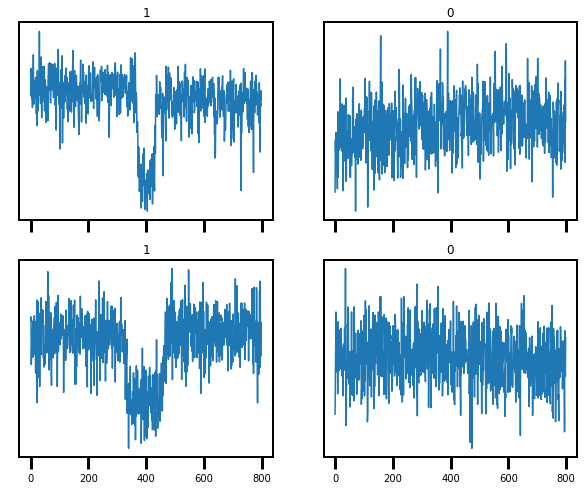

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(10,8),
                                             sharex=True)
ax1.plot(x_train[ind_ye[62]])
ax1.set_title(y_train[ind_ye[67]])

ax2.plot(x_train[ind_no[68]])
ax2.set_title(y_train[ind_no[68]])

ax3.plot(x_train[ind_ye[74]])
ax3.set_title(y_train[ind_ye[74]])

ax4.plot(x_train[ind_no[70]])
ax4.set_title(y_train[ind_no[70]])

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([]);

#plt.savefig('training_set.png', dpi=200, rasterize=True)

## Creating da net (same format as stella)

In [15]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.3.0'

In [16]:
np.random.seed(0)
tf.random.set_seed(0)

keras.backend.clear_session()

model = keras.models.Sequential()

filter1 = 16
filter2 = 64
dense = 32
dropout = 0.1
ks = 7

model.add(tf.keras.layers.Conv1D(filters=filter1, kernel_size=ks,
                                 activation='relu', padding='same',
                                 input_shape=(CADENCES, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Conv1D(filters=filter2, kernel_size=int(ks/2),
                                 activation='relu', padding='same',
                                 input_shape=(CADENCES, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(dense, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy', tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 800, 16)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 400, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 400, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

## history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=64, 
                    shuffle=False,
                    validation_data=(x_val, y_val))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4), sharex=True)

ax1.plot(history.epoch, history.history['accuracy'], 'k',
        label='train')
ax1.plot(history.epoch, history.history['val_accuracy'], 'r',
        label='val')
ax1.set_ylabel('accuracy')
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], 'k')
ax2.plot(history.epoch, history.history['val_loss'], 'r')
ax2.set_ylabel('loss')

ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')

#plt.savefig('test3_sample_models_different.png', dpi=200, rasterize=True)

In [ ]:
val_pred = model.predict(x_val)
val_pred = np.reshape(val_pred, len(val_pred))

threshold = 0.75

rounded = np.copy(val_pred)
rounded[rounded>threshold] = 1
rounded[rounded<=threshold] = 0
rounded = np.array(rounded, dtype=int)

In [ ]:
tp = np.unique(np.where((rounded==1) & (y_val==1))[0])
tn = np.unique(np.where((rounded==0) & (y_val==0))[0])

fp = np.unique(np.where((rounded==1) & (y_val==0))[0])
fn = np.unique(np.where((rounded==0) & (y_val==1))[0])

In [ ]:
print("True positives:", len(tp)/len(rounded), len(y_val[y_val==1])/len(y_val))
print("True negatives:", len(tn)/len(rounded), len(y_val[y_val==0])/len(y_val))

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharex=True)
i = 60

for ax in axes.reshape(-1):
    ax.plot(x_val[fp[i]])
    ax.set_title('Predicted Prob: ' + str(val_pred[fp[i]]))
    
    if i > 7:
        ax.set_xlabel('cadences')
    i += 1
    
#plt.savefig('false_positives.png', dpi=200, rasterize=True)

In [ ]:
prec, rec, _ = precision_recall_curve(y_val, val_pred)

In [ ]:
plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall');